# Библиотеки и пути до файлов

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Загрузка данных из Excel файлов
data_folder = Path("data/xlsx/")
all_dataframes = []

for file_path in data_folder.rglob("*.xlsx"):
    current_df = pd.read_excel(file_path, index_col=0)
    all_dataframes.append(current_df)

# Загрузка данных из CSV файлов
train_data = pd.read_excel('data/train.xlsx')
test_data = pd.read_excel('data/test.xlsx')
all_dataframes.append(train_data)
all_dataframes.append(test_data)

In [3]:
# Объединение всех данных с сохранением всех столбцов
combined_data = pd.concat(all_dataframes, axis=0, ignore_index=True, sort=False)

# Преобразование столбца 'dt' в datetime
combined_data['dt'] = pd.to_datetime(combined_data['dt'])

# Сортировка данных по дате
combined_data = combined_data.sort_values(by='dt')

In [4]:
# Группировка по неделям и выбор первого значения за каждую неделю
combined_data['week'] = combined_data['dt'].dt.to_period('W')
weekly_data = combined_data.groupby('week').agg('first').reset_index()
weekly_data = weekly_data.drop(columns='week')

In [6]:
# Удаление строк с пропущенными значениями в столбце "Цена на арматуру"
weekly_data = weekly_data.dropna(subset=["Price"])

# Вычисление доли пропущенных значений в каждом столбце
missing_values_ratio = weekly_data.isnull().mean()

# Удаление столбцов с долей пропусков более 30%
columns_to_remove = missing_values_ratio[missing_values_ratio > 0.3].index
cleaned_data = weekly_data.drop(columns=columns_to_remove)

In [7]:
# Заполнение пропущенных значений
cleaned_data = cleaned_data.interpolate(method='linear').fillna(method='bfill')  # заполнение назад
cleaned_data = cleaned_data.interpolate(method='linear').fillna(method='ffill')  # заполнение вперёд

C:\Users\Виктор\AppData\Local\Temp\ipykernel_10760\1069677959.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data = cleaned_data.interpolate(method='linear').fillna(method='bfill')  # заполнение назад
C:\Users\Виктор\AppData\Local\Temp\ipykernel_10760\1069677959.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data = cleaned_data.interpolate(method='linear').fillna(method='ffill')  # заполнение вперёд


In [8]:
# Вывод информации о данных
print("Информация о combined_data:")
print(combined_data.info())

print("\nИнформация о cleaned_data:")
print(cleaned_data.info())

Информация о combined_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      428 non-null    datetime64[ns]
 1   Price   428 non-null    int64         
 2   week    428 non-null    period[W-SUN] 
dtypes: datetime64[ns](1), int64(1), period[W-SUN](1)
memory usage: 10.2 KB
None

Информация о cleaned_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   dt      428 non-null    datetime64[ns]
 1   Price   428 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.8 KB
None


<Axes: >

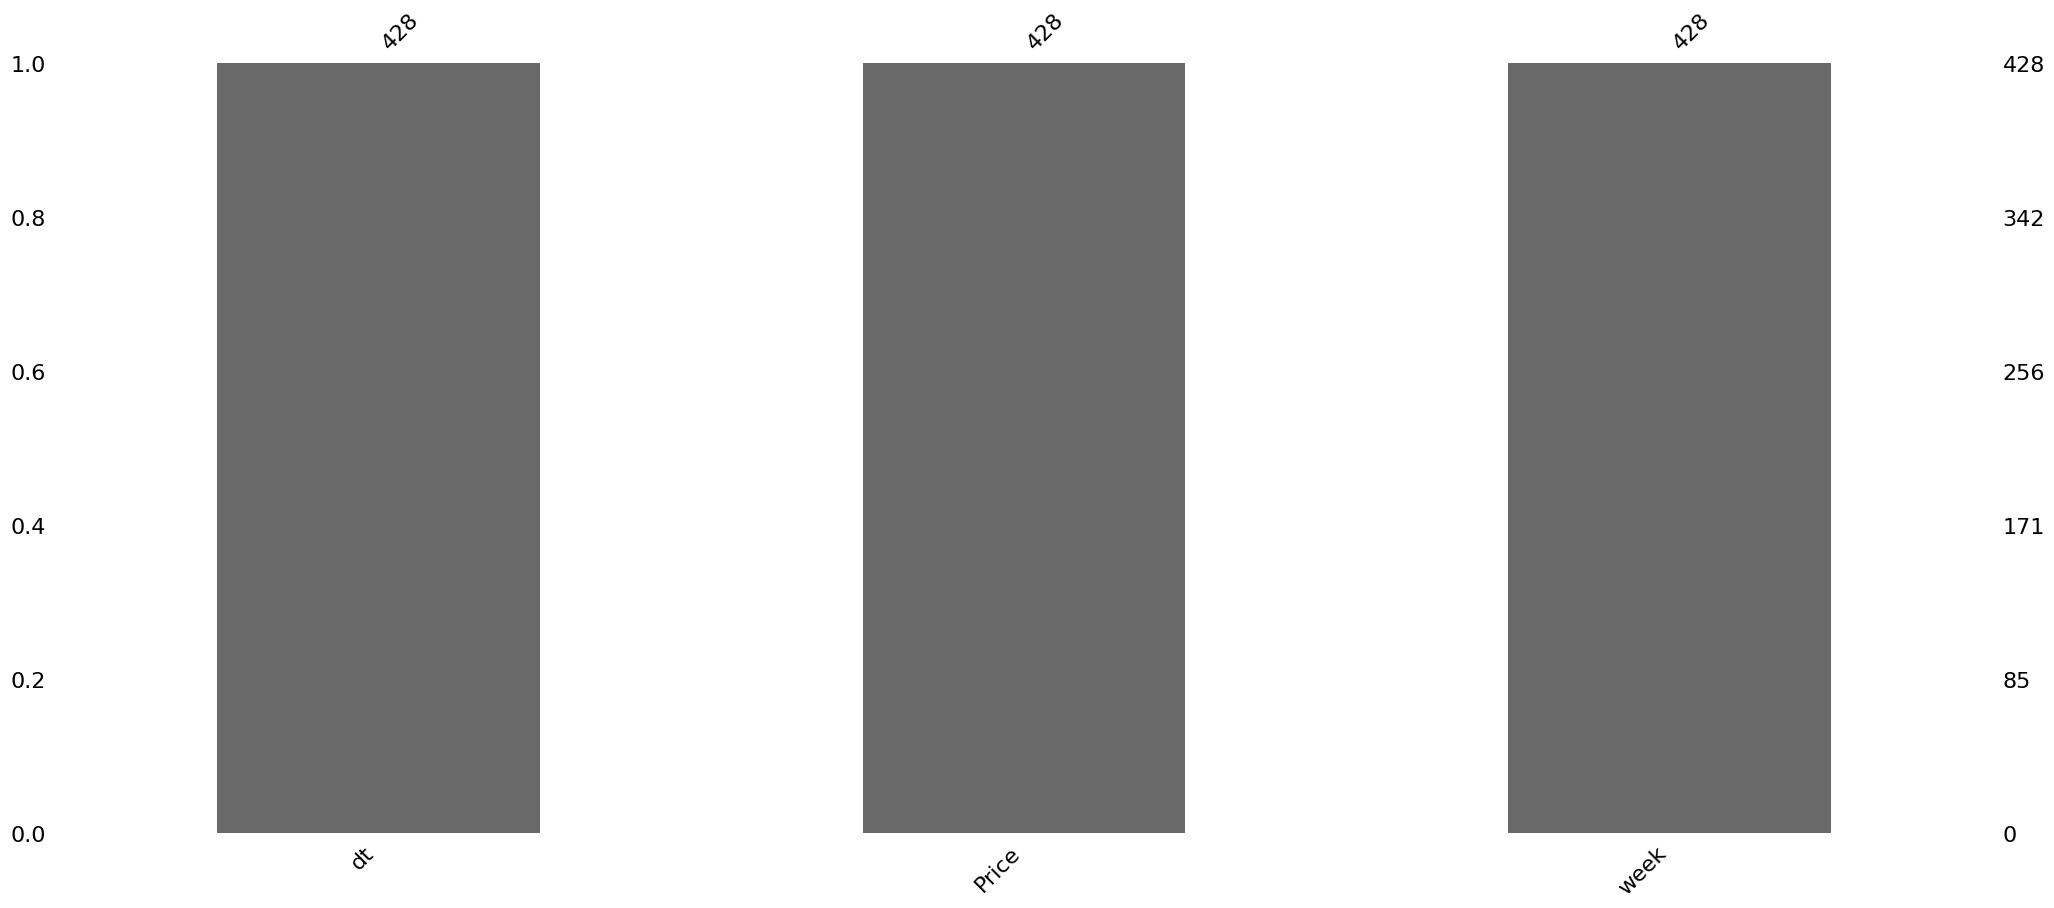

In [9]:
msno.bar(combined_data)

<Axes: >

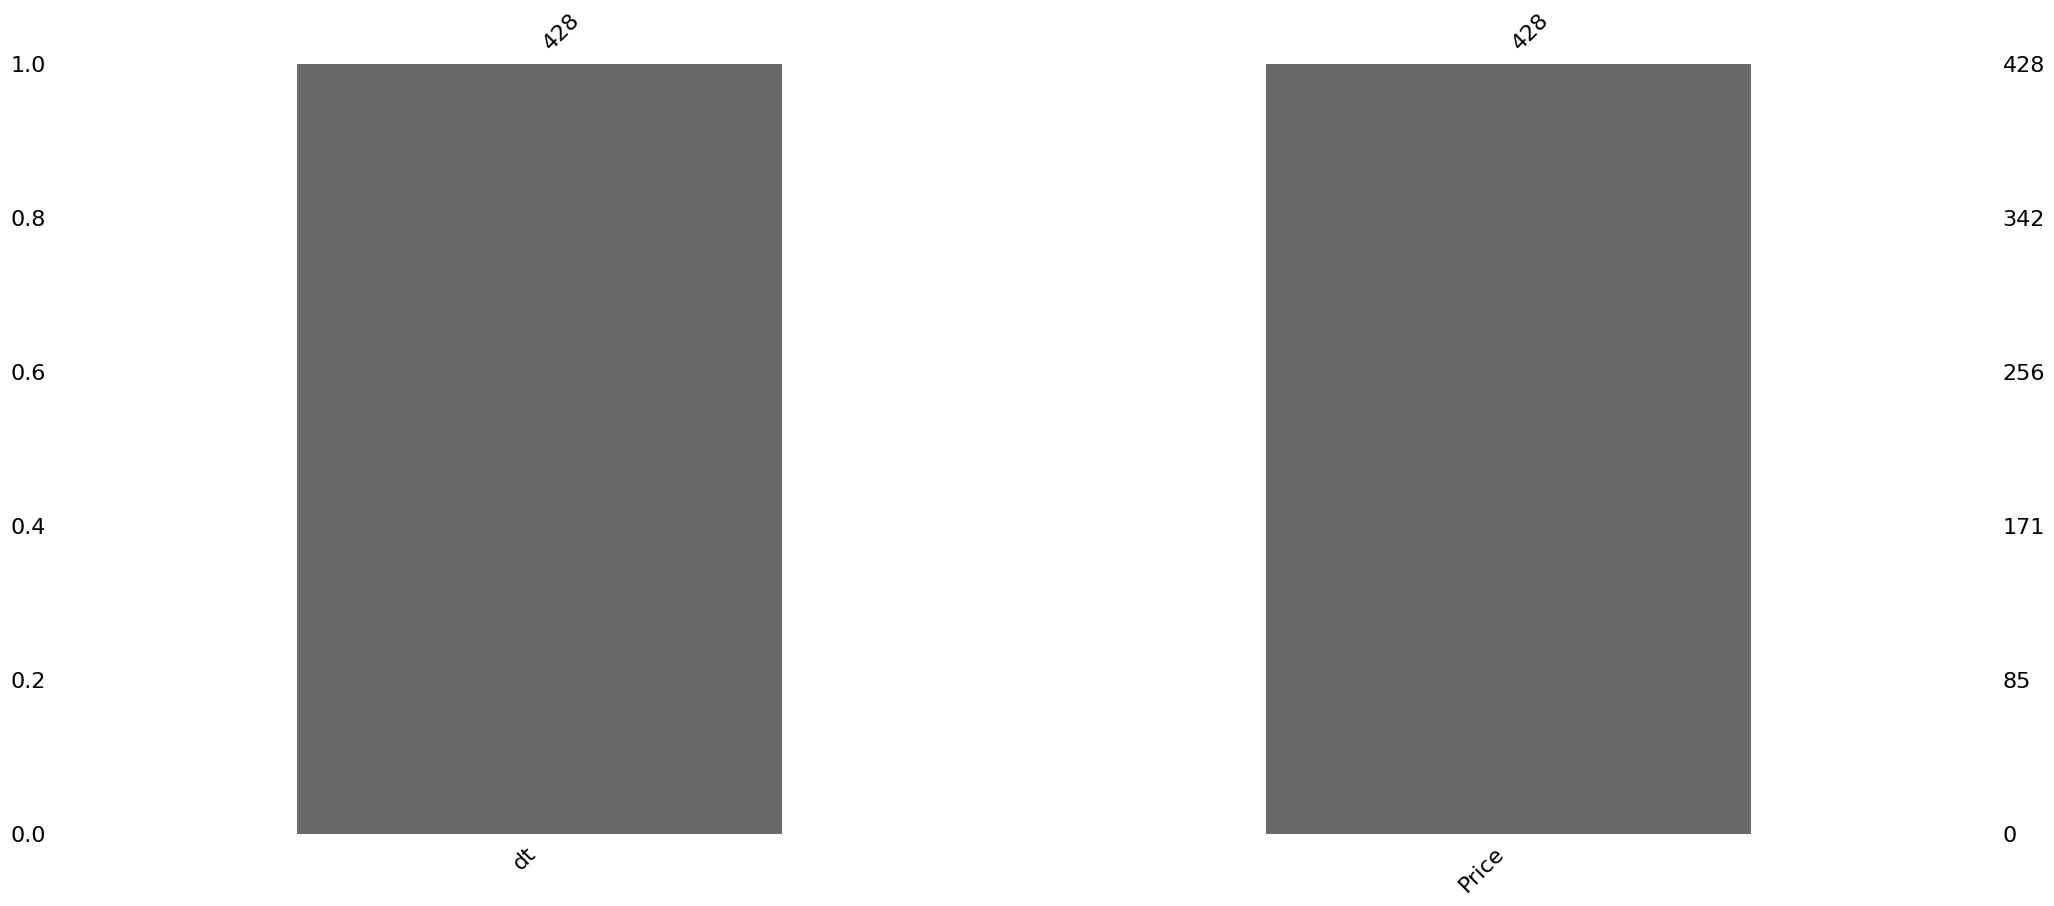

In [10]:
msno.bar(cleaned_data)

In [12]:
# Преобразование столбца 'dt' в числовой формат для тепловой карты
# Используем временные метки (timestamp) в виде чисел
combined_data['dt_numeric'] = combined_data['dt'].astype('int64')  # Преобразуем в наносекунды

# Построение тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(combined_data.set_index('dt_numeric'), annot=True, fmt=".1f", cmap="viridis")
plt.title("Тепловая карта данных")
plt.xlabel("Дата (числовой формат)")
plt.ylabel("Столбцы")
plt.show()

# Возвращаем столбец 'dt' обратно в datetime
combined_data['dt'] = pd.to_datetime(combined_data['dt'])

TypeError: float() argument must be a string or a real number, not 'Period'

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Матрица корреляции для cleaned_data
correlation_matrix_cleaned = cleaned_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Матрица корреляции (cleaned_data)")
plt.show()

TypeError: float() argument must be a string or a real number, not 'Period'

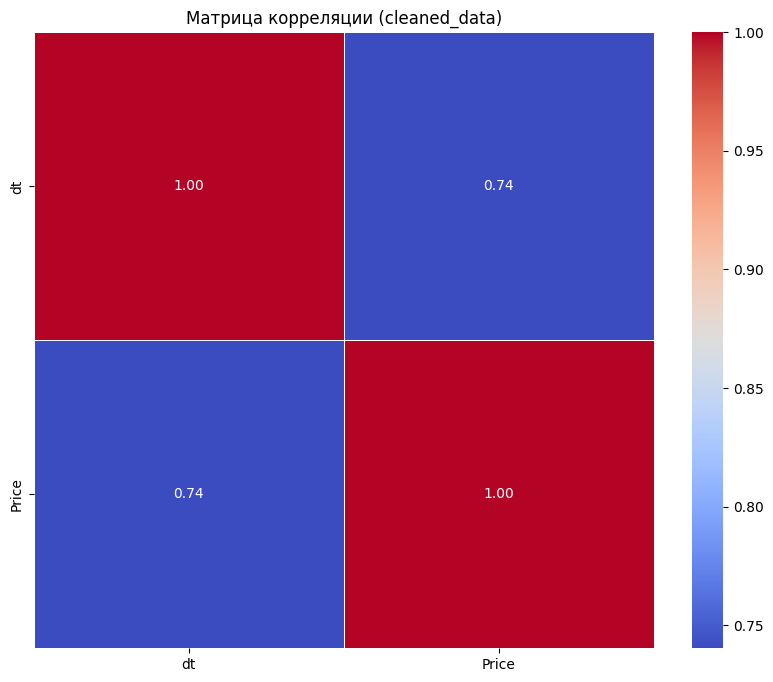

In [ ]:
# Матрица корреляции для cleaned_data
correlation_matrix_cleaned = cleaned_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_cleaned, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Матрица корреляции (cleaned_data)")
plt.show()

In [ ]:
# Сохранение очищенных данных в CSV
cleaned_data.to_csv("cleaned_data.csv", index=False)

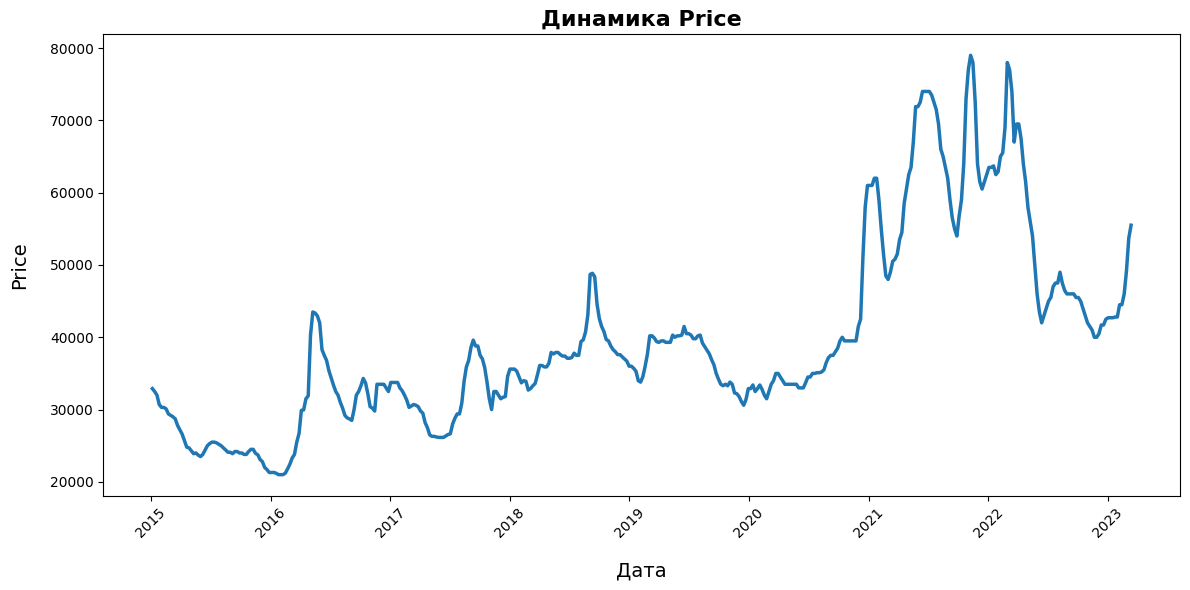

In [ ]:
# Построение графиков для каждого столбца (кроме 'dt')
for column in cleaned_data.columns[1:]:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='dt', y=column, data=cleaned_data, linewidth=2.5)
    
    plt.title(f"Динамика {column}", fontsize=16, fontweight='bold')
    plt.xlabel('Дата', labelpad=15, fontsize=14)
    plt.ylabel(column, labelpad=15, fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()